Calculating global minimum accuracy...
Global minimum f1: 2.2%

Creating heatmap for vessel...


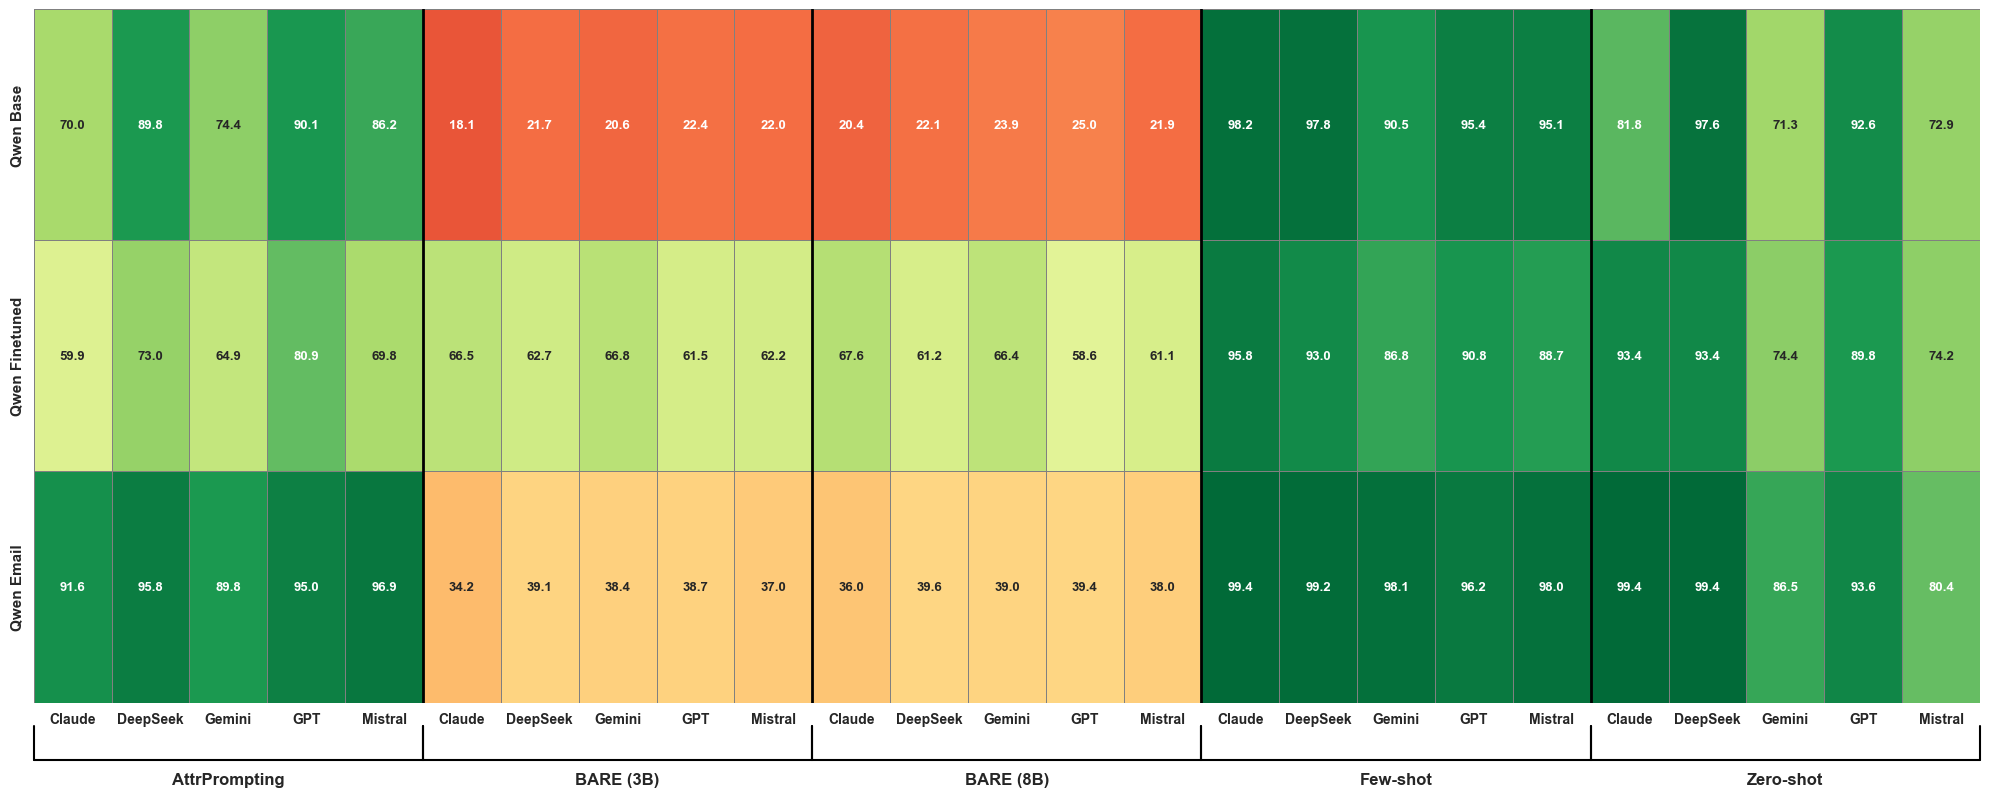


Creating heatmap for port...


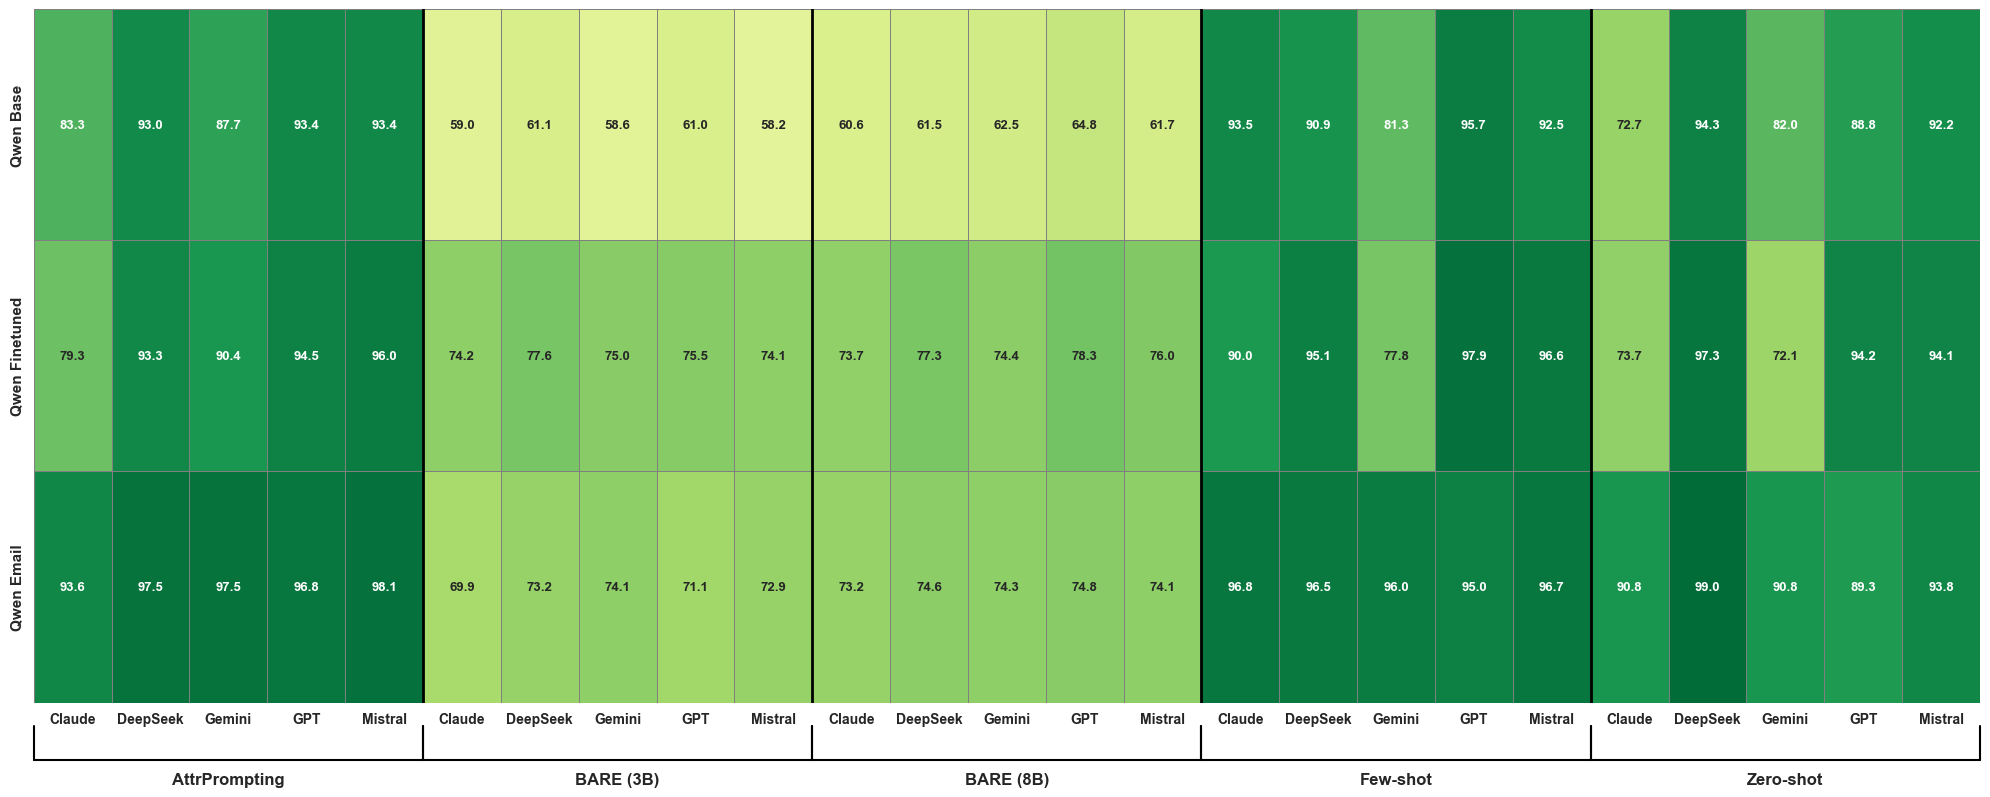


Creating heatmap for commodity...


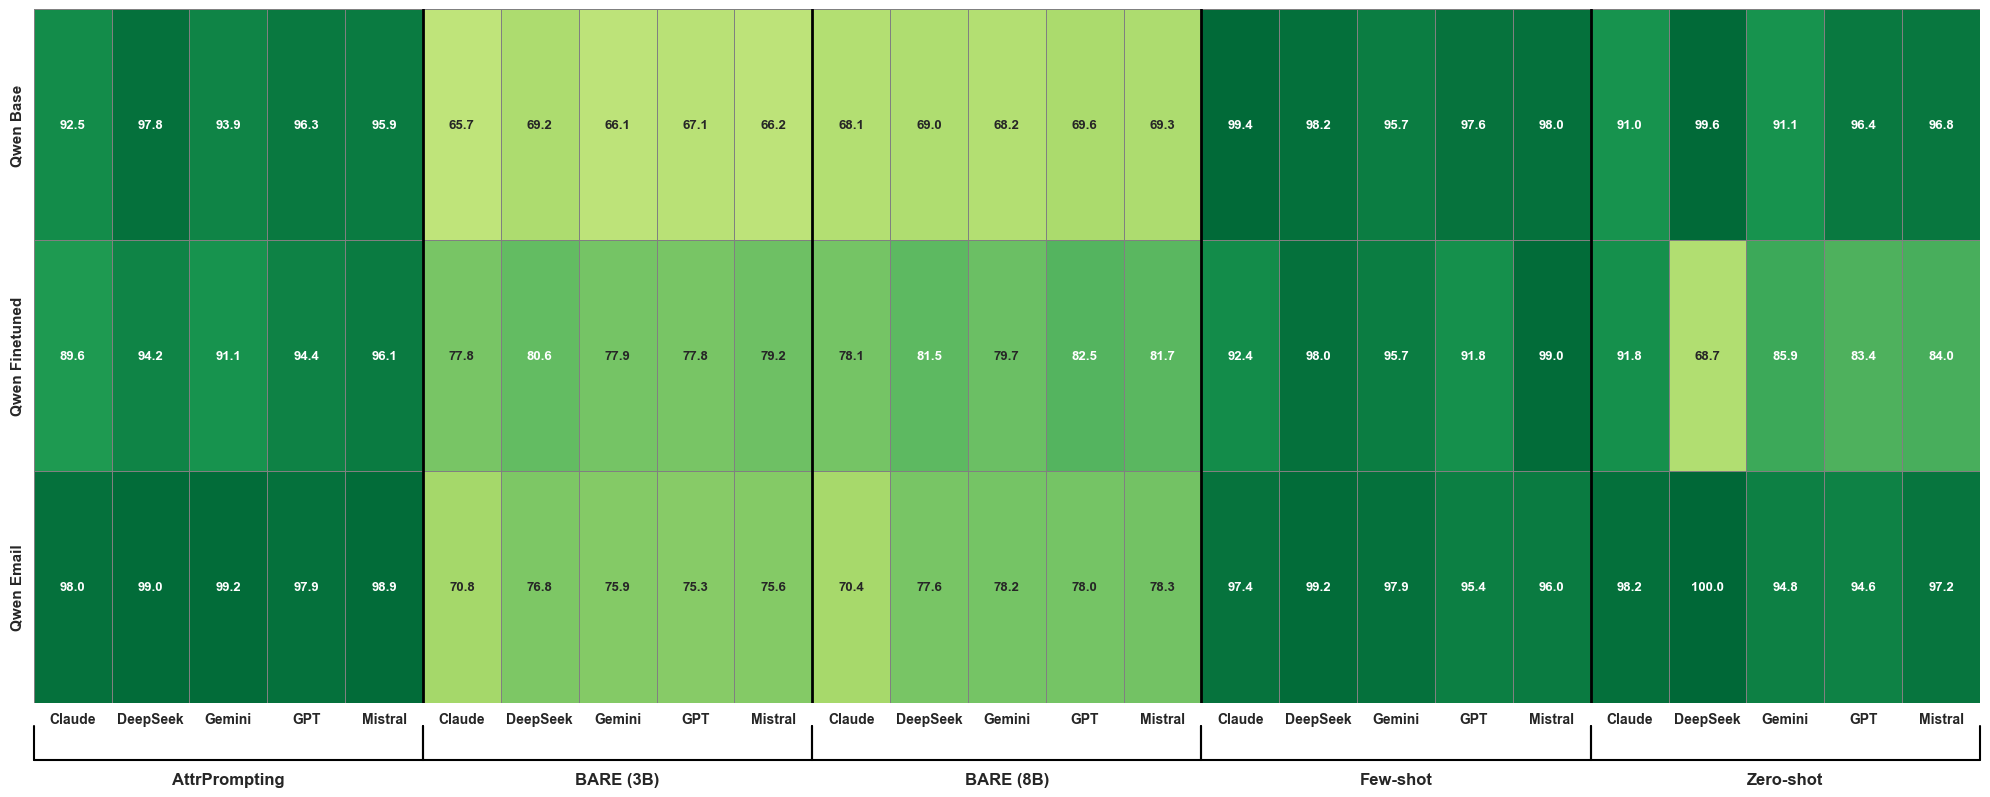


Creating heatmap for incoterm...


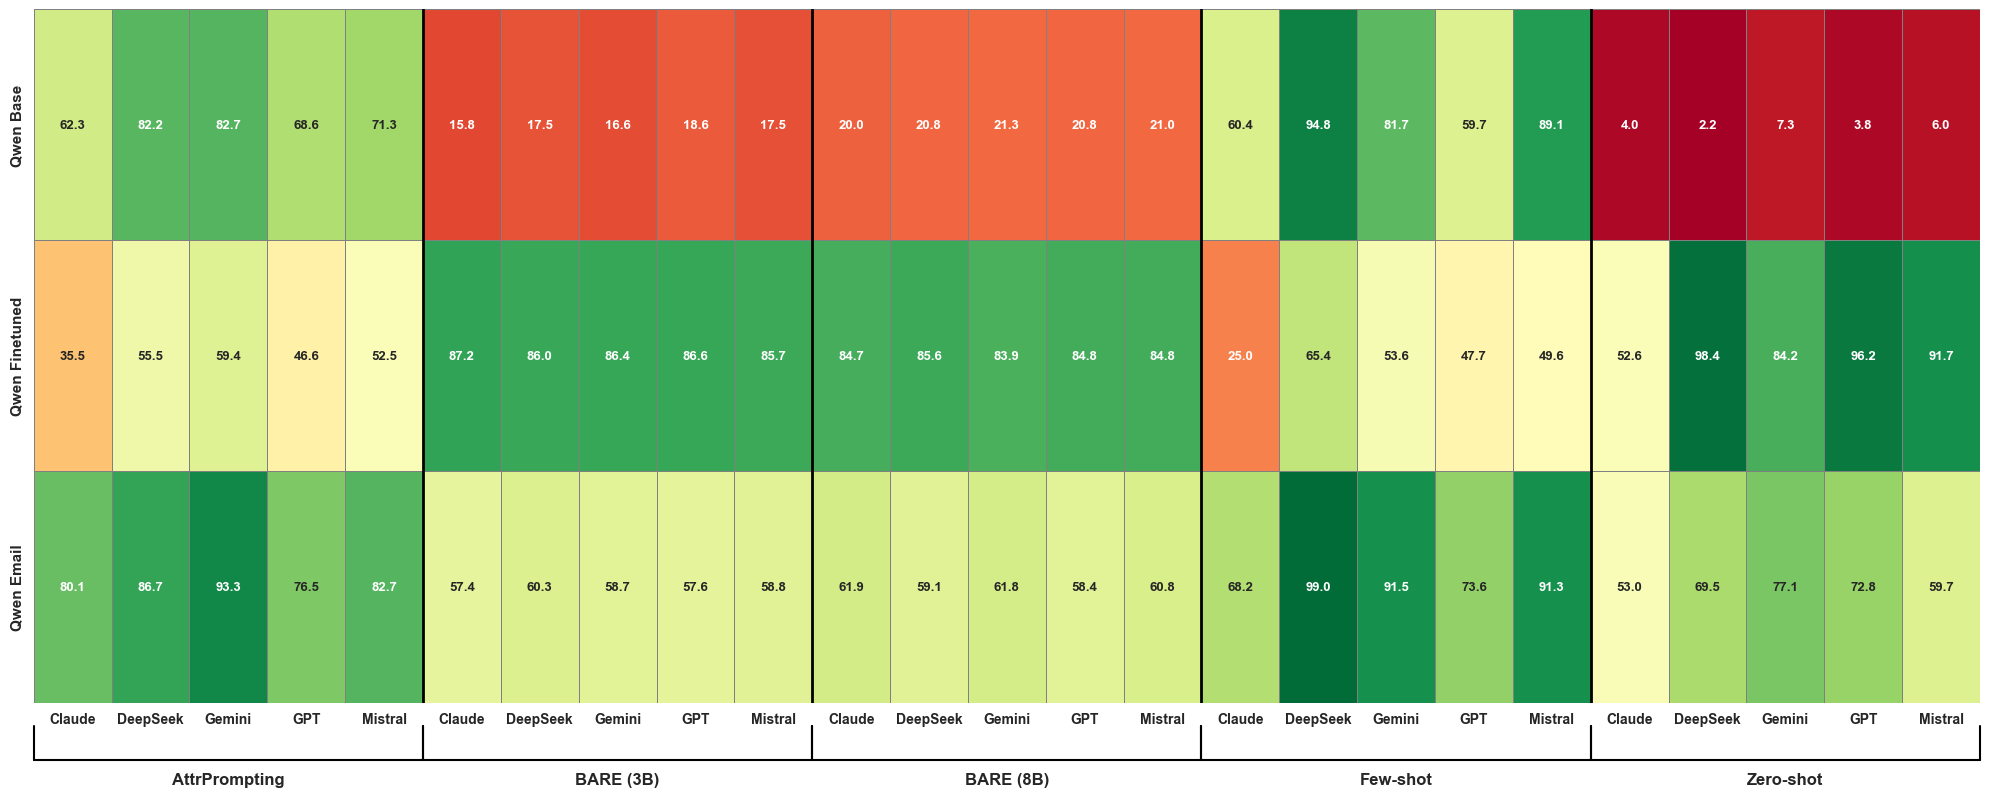


Creating overall heatmap...


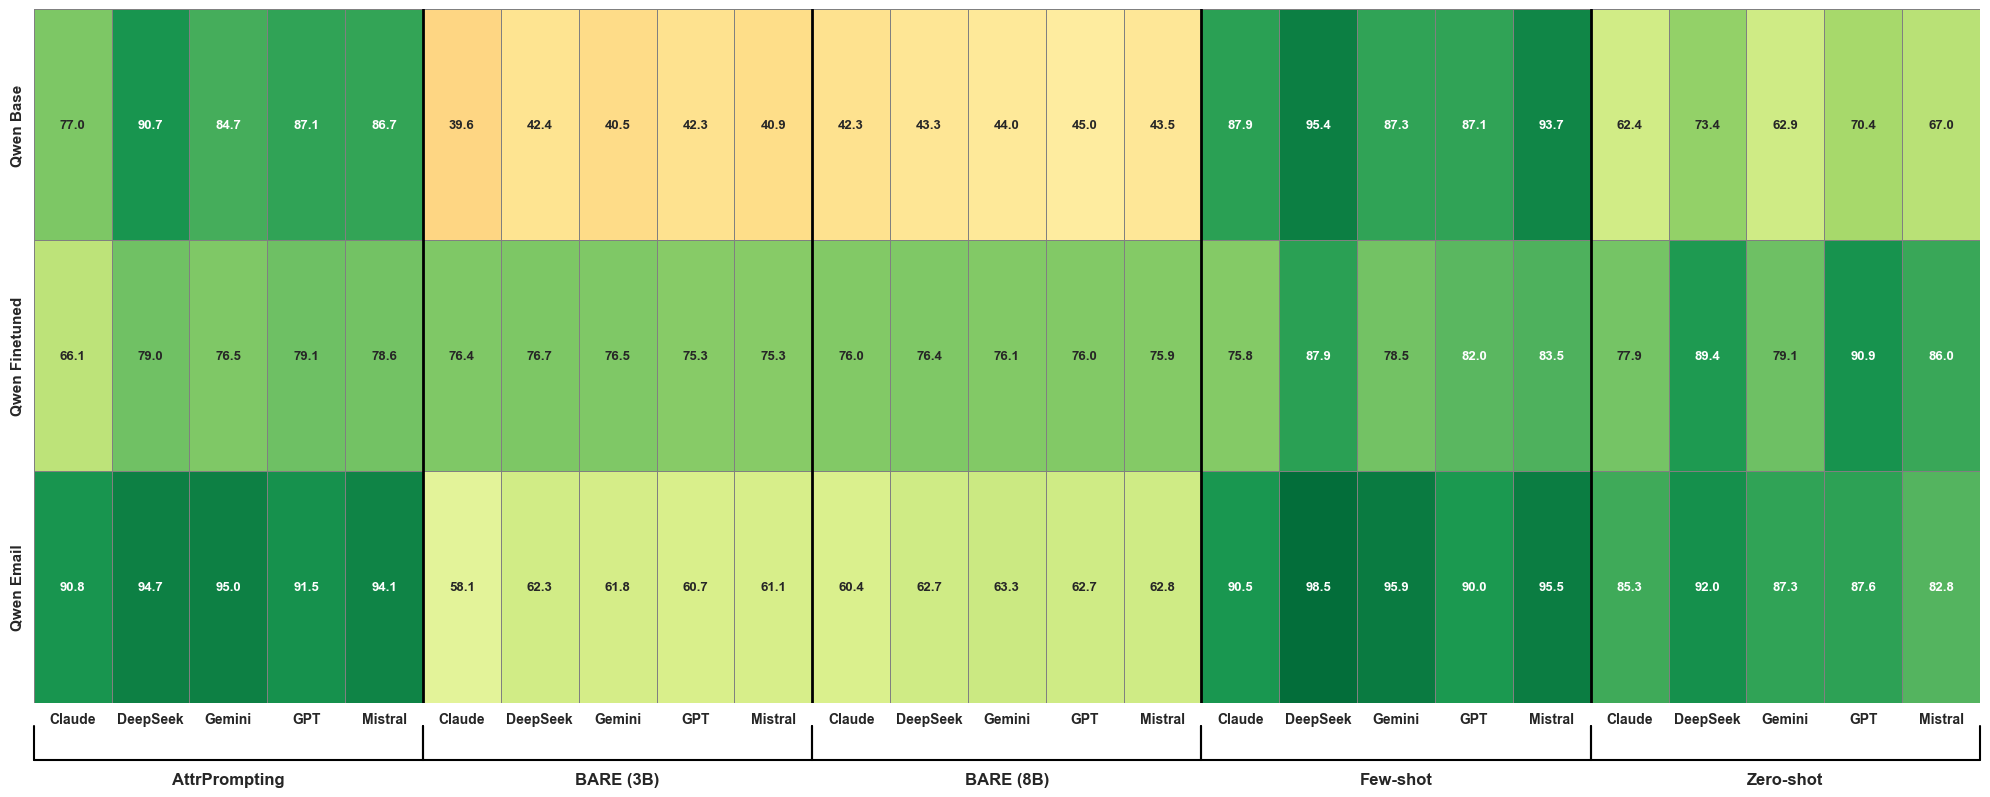

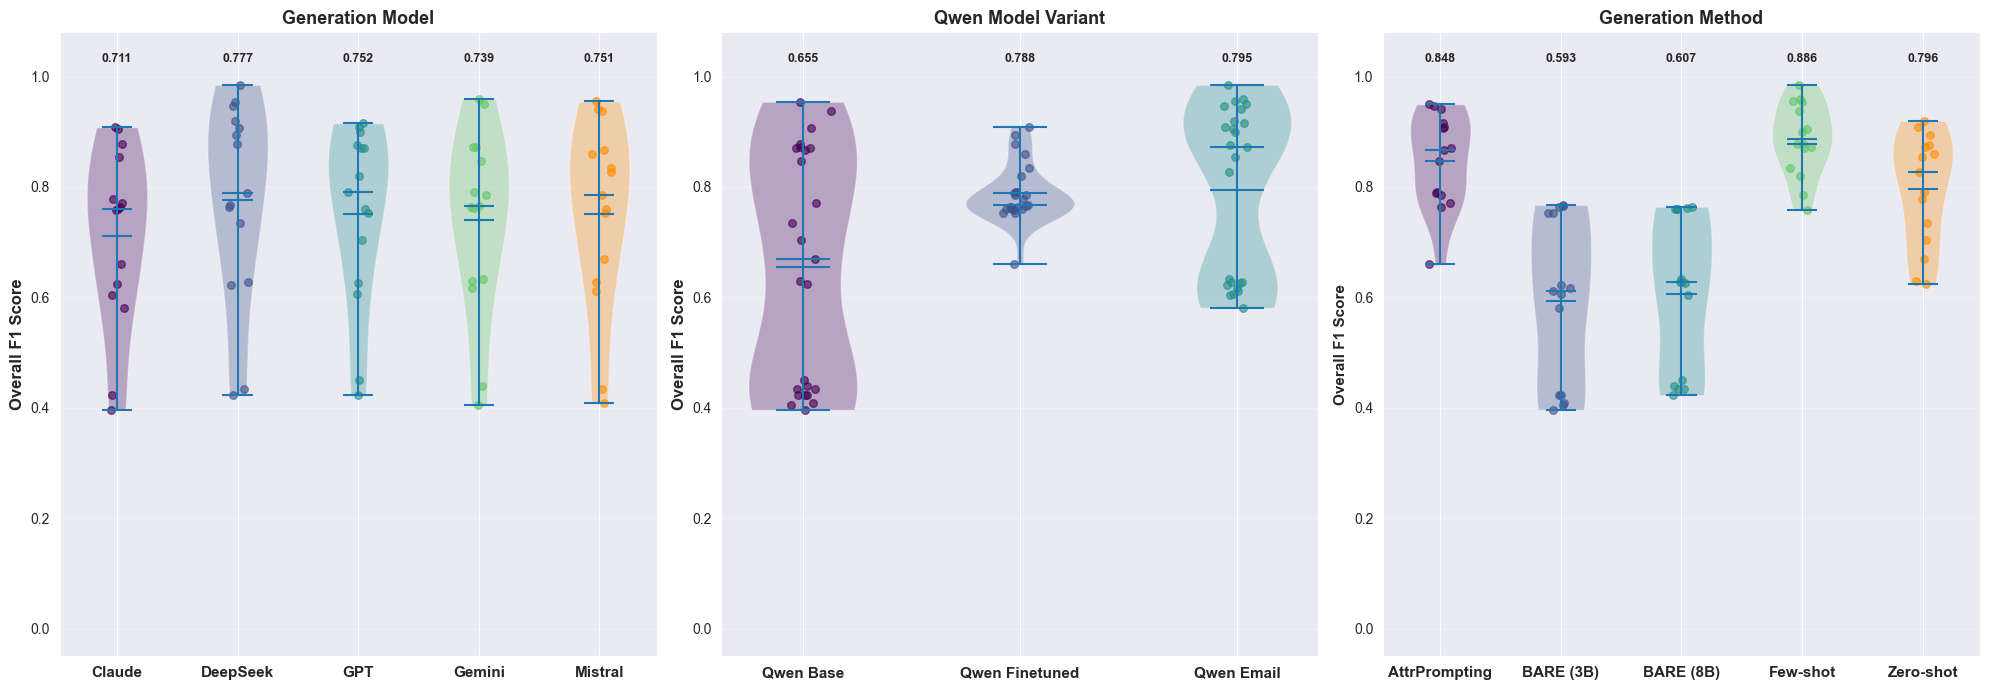

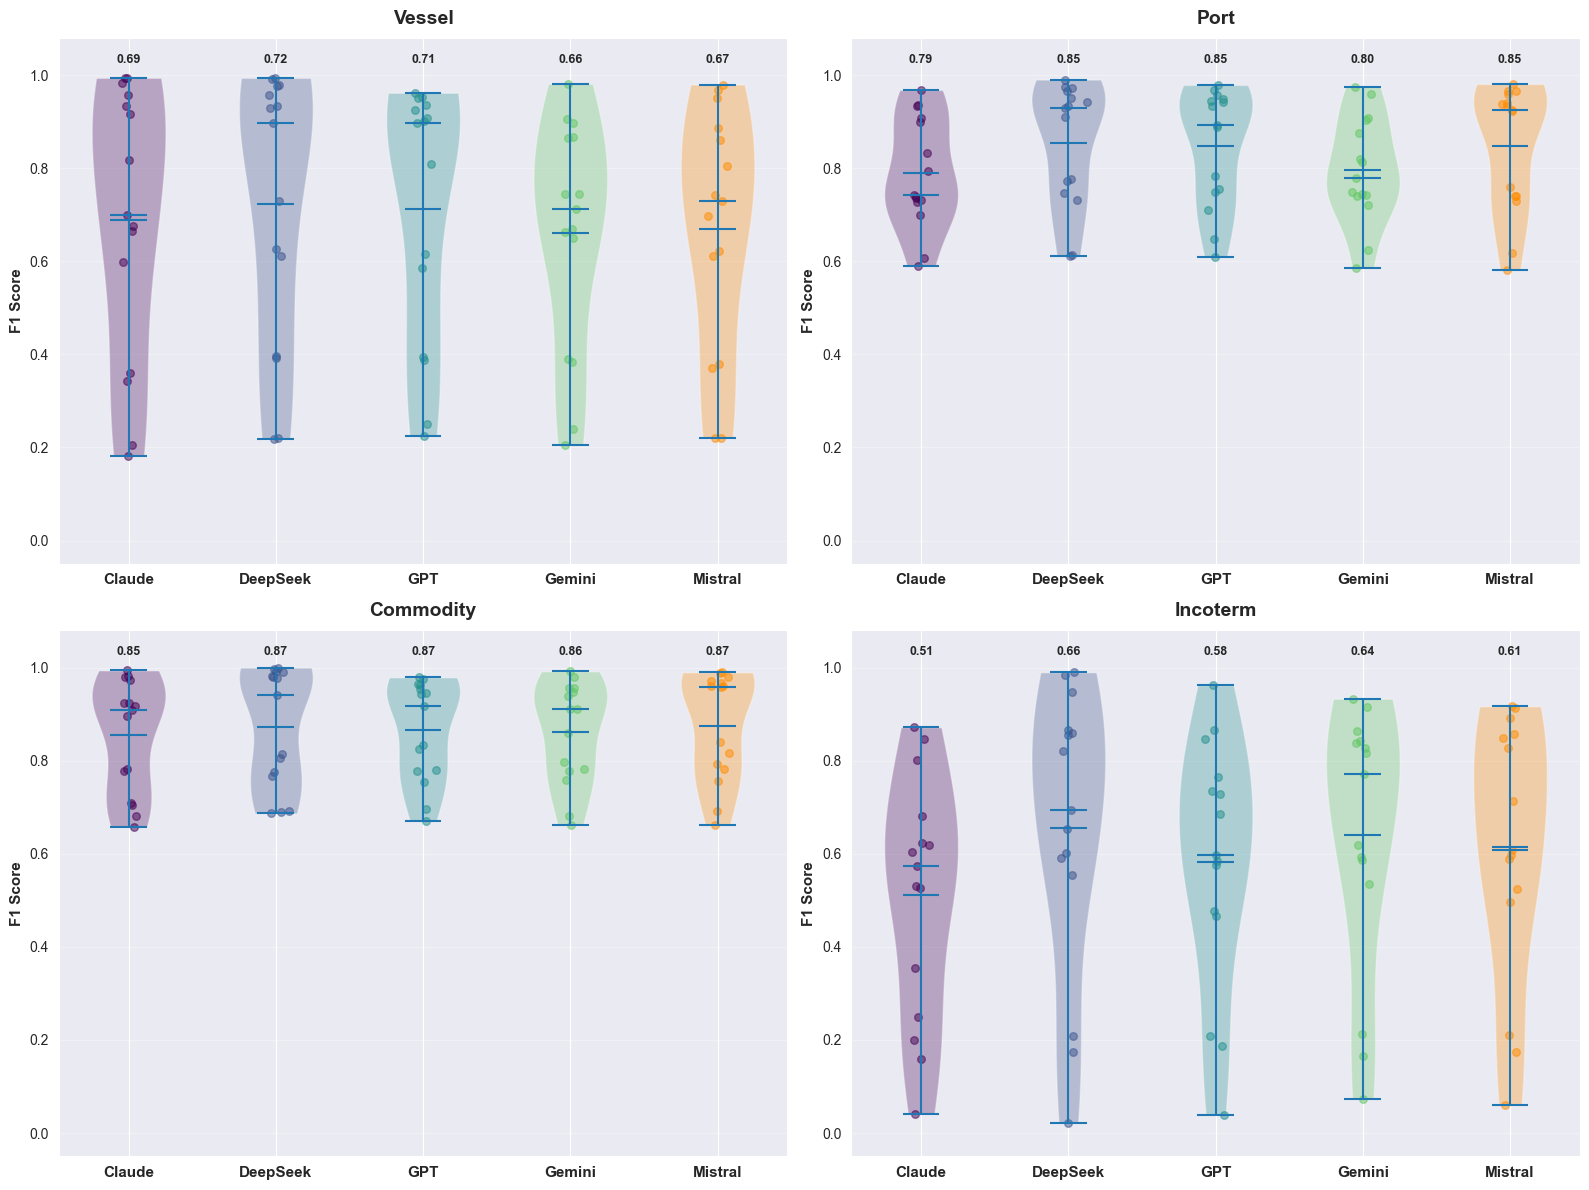


=== Summary Statistics ===

Mean F1 scores by model:
Qwen Base: 0.655
Qwen Finetuned: 0.788
Qwen Email: 0.795

Mean F1 scores by generation method:
AttrPrompting: 0.848
BARE (3B): 0.593
BARE (8B): 0.607
Few-shot: 0.886
Zero-shot: 0.796

Mean F1 scores by generation model:
Claude: 0.711
DeepSeek: 0.777
GPT: 0.752
Gemini: 0.739
Mistral: 0.751


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.cm import viridis
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------
# Data Reading
# -------------------------------------------------------------------
df = pd.read_csv(r"C:\Users\brk.ch\Work Folders\RF\Desktop\Master Thesis\Repo\Masterthesis-dev\llm_finetuning\eval_results\qwen_metrics_substring.csv")

# -------------------------------------------------------------------
# Model Groups
# -------------------------------------------------------------------
model_order = ['qwen_base', 'qwen_finetuned', 'qwen_email']

# Model Renaming Dictionary
model_rename_dict = {
    'qwen_base': 'Qwen Base',
    'qwen_finetuned': 'Qwen Finetuned',
    'qwen_email': 'Qwen Email'
}

entity_types = ['vessel', 'port', 'commodity', 'incoterm']
all_datasets = sorted(df['dataset'].unique())

# -------------------------------------------------------------------
# Parsing Dataset Names
# -------------------------------------------------------------------
def parse_dataset_info(dataset_name):
    """Parse dataset name to extract generation type and model"""
    parts = dataset_name.split('_')

    if 'attr_prompting' in dataset_name:
        gen_type = 'AttrPrompting'
        model_name = parts[-1]

    elif 'bare_llama_3b' in dataset_name:
        gen_type = 'BARE (3B)'
        model_name = parts[-1]

    elif 'bare_llama_8b' in dataset_name:
        gen_type = 'BARE (8B)'
        model_name = parts[-1]

    elif 'fewshot' in dataset_name:
        gen_type = 'Few-shot'
        model_name = parts[-1]

    elif 'zeroshot' in dataset_name:
        gen_type = 'Zero-shot'
        model_name = parts[-1]

    else:
        gen_type = 'Unknown'
        model_name = dataset_name

    if model_name.lower() == 'gpt':
        model = 'GPT'
    elif model_name.lower() == 'deepseek':
        model = 'DeepSeek'
    elif model_name.lower() == 'gemini':
        model = 'Gemini'
    elif model_name.lower() == 'claude':
        model = 'Claude'
    elif model_name.lower() == 'mistral':
        model = 'Mistral'
    else:
        model = model_name.capitalize()

    return gen_type, model

# -------------------------------------------------------------------
# Calculate Overall F1 Score
# -------------------------------------------------------------------
def calculate_overall_f1(row):
    """Calculate overall F1 as average of individual entity F1 scores"""
    entity_f1s = [row['vessel_f1'], row['port_f1'], row['commodity_f1'], row['incoterm_f1']]
    return np.mean(entity_f1s)

df['overall_f1'] = df.apply(calculate_overall_f1, axis=1)

df['generation_model'] = df['dataset'].apply(lambda x: parse_dataset_info(x)[1])
df['generation_method'] = df['dataset'].apply(lambda x: parse_dataset_info(x)[0])

# -------------------------------------------------------------------
# Calculate Global Minimum for Heatmaps
# -------------------------------------------------------------------
print("Calculating global minimum accuracy...")
global_min = 100.0
for entity in entity_types:
    for model in model_order:
        if model in df['model'].values:
            for dataset in all_datasets:
                mask = (df['model'] == model) & (df['dataset'] == dataset)
                if mask.any():
                    accuracy = df.loc[mask, f'{entity}_f1'].values[0] * 100
                    if accuracy < global_min:
                        global_min = accuracy

print(f"Global minimum f1: {global_min:.1f}%")

# -------------------------------------------------------------------
# HEATMAP VISUALIZATIONS
# -------------------------------------------------------------------

for entity in entity_types:
    print(f"\nCreating heatmap for {entity}...")

    fig, ax = plt.subplots(figsize=(20, 8))

    all_data = []
    all_model_names = []

    for model in model_order:
        if model in df['model'].values:
            renamed_model = model_rename_dict.get(model, model)
            all_model_names.append(renamed_model)
            row_data = []
            for dataset in all_datasets:
                mask = (df['model'] == model) & (df['dataset'] == dataset)
                if mask.any():
                    accuracy = df.loc[mask, f'{entity}_f1'].values[0]
                    row_data.append(accuracy * 100)
                else:
                    row_data.append(np.nan)
            all_data.append(row_data)

    combined_df = pd.DataFrame(all_data, columns=all_datasets, index=all_model_names)

    dataset_info = [parse_dataset_info(d) for d in all_datasets]
    generation_types = [info[0] for info in dataset_info]
    model_names = [info[1] for info in dataset_info]

    sns.heatmap(combined_df,
               ax=ax,
               cmap='RdYlGn',
               vmin=global_min,
               vmax=100.0,
               annot=True,
               fmt='.1f',
               cbar=False,
               linewidths=0.5,
               linecolor='gray',
               annot_kws={'size': 9.5, 'fontweight': 'bold'})

    ax.set_xticklabels(model_names, rotation=0, ha='center', fontsize=10, fontweight="bold")

    gen_type_groups = []
    current_type = generation_types[0]
    start_idx = 0

    for i, gen_type in enumerate(generation_types + ['END']):
        if i == len(generation_types) or gen_type != current_type:
            gen_type_groups.append((current_type, start_idx, i-1))
            if i < len(generation_types):
                current_type = gen_type
                start_idx = i

    for i, (gen_type, start, end) in enumerate(gen_type_groups[1:], 1):
        ax.axvline(x=start, color='black', linewidth=2)

    for gen_type, start, end in gen_type_groups:
        center = (start + end) / 2
        ax.text(center + 0.5, len(combined_df) + 0.3, gen_type,
                ha='center', va='top', fontsize=12, fontweight='bold',
                transform=ax.transData)

        if end > start:
            ax.plot([start, start], [len(combined_df) + 0.1, len(combined_df) + 0.25],
                   'k-', transform=ax.transData, clip_on=False)
            ax.plot([end + 1, end + 1], [len(combined_df) + 0.1, len(combined_df) + 0.25],
                   'k-', transform=ax.transData, clip_on=False)
            ax.plot([start, end + 1], [len(combined_df) + 0.25, len(combined_df) + 0.25],
                   'k-', transform=ax.transData, clip_on=False)

    ax.set_yticklabels(ax.get_yticklabels(), fontsize=11, fontweight="bold")

    plt.tight_layout()
    plt.savefig(f'qwen_heatmap_{entity}.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\nCreating overall heatmap...")
fig, ax = plt.subplots(figsize=(20, 8))

all_data = []
all_model_names = []

for model in model_order:
    if model in df['model'].values:
        renamed_model = model_rename_dict.get(model, model)
        all_model_names.append(renamed_model)
        row_data = []
        for dataset in all_datasets:
            mask = (df['model'] == model) & (df['dataset'] == dataset)
            if mask.any():
                overall_acc = df.loc[mask, 'overall_f1'].values[0]
                row_data.append(overall_acc * 100)
            else:
                row_data.append(np.nan)
        all_data.append(row_data)

combined_df = pd.DataFrame(all_data, columns=all_datasets, index=all_model_names)

dataset_info = [parse_dataset_info(d) for d in all_datasets]
generation_types = [info[0] for info in dataset_info]
model_names = [info[1] for info in dataset_info]

sns.heatmap(combined_df,
           ax=ax,
           cmap='RdYlGn',
           vmin=global_min,
           vmax=100.0,
           annot=True,
           fmt='.1f',
           cbar=False,
           linewidths=0.5,
           linecolor='gray',
           annot_kws={'size': 9.5, 'fontweight': 'bold'})

ax.set_xticklabels(model_names, rotation=0, ha='center', fontsize=10, fontweight="bold")

gen_type_groups = []
current_type = generation_types[0]
start_idx = 0

for i, gen_type in enumerate(generation_types + ['END']):
    if i == len(generation_types) or gen_type != current_type:
        gen_type_groups.append((current_type, start_idx, i-1))
        if i < len(generation_types):
            current_type = gen_type
            start_idx = i

for i, (gen_type, start, end) in enumerate(gen_type_groups[1:], 1):
    ax.axvline(x=start, color='black', linewidth=2)

for gen_type, start, end in gen_type_groups:
    center = (start + end) / 2
    ax.text(center + 0.5, len(combined_df) + 0.3, gen_type,
            ha='center', va='top', fontsize=12, fontweight='bold',
            transform=ax.transData)

    if end > start:
        ax.plot([start, start], [len(combined_df) + 0.1, len(combined_df) + 0.25],
               'k-', transform=ax.transData, clip_on=False)
        ax.plot([end + 1, end + 1], [len(combined_df) + 0.1, len(combined_df) + 0.25],
               'k-', transform=ax.transData, clip_on=False)
        ax.plot([start, end + 1], [len(combined_df) + 0.25, len(combined_df) + 0.25],
               'k-', transform=ax.transData, clip_on=False)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=11, fontweight="bold")

plt.tight_layout()
plt.savefig('qwen_heatmap_overall.png', dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------
# VIOLIN PLOT VISUALIZATIONS
# -------------------------------------------------------------------
def get_custom_colors(n):
    """Get n evenly spaced colors from purple to orange"""
    colors = ['#440154', '#3b528b', '#21908c', '#5dc863', '#fde725']
    colors = ['#440154', '#3b528b', '#21908c', '#5dc863', '#ff8c00']
    
    cmap = mcolors.LinearSegmentedColormap.from_list('purple_to_orange', colors)
    
    return [cmap(i / (n - 1)) for i in range(n)]

def get_viridis_colors(n):
    """Get n evenly spaced colors from the viridis colormap"""
    return [viridis(i / (n - 1)) for i in range(n)]

gen_model_order = sorted(df['generation_model'].unique())
gen_method_order = sorted(df['generation_method'].unique())

max_categories = max(len(gen_model_order), len(model_order), len(gen_method_order))
base_colors = get_custom_colors(max_categories)

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

ax = axes[0]
models = gen_model_order
violin_data = [df[df['generation_model'] == model]['overall_f1'].values for model in models]
violin_parts = ax.violinplot(violin_data, positions=range(len(models)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.3)

for i, model in enumerate(models):
    data = df[df['generation_model'] == model]['overall_f1'].values
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=30, color=base_colors[i])

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=12, fontweight="bold")
ax.set_title('Generation Model', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

ax = axes[1]
model_types = [model_rename_dict[m] for m in model_order if m in df['model'].unique()]
violin_data = [df[df['model'] == model]['overall_f1'].values for model in model_order if model in df['model'].unique()]
violin_parts = ax.violinplot(violin_data, positions=range(len(model_types)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.3)

for i, (model, model_type) in enumerate(zip([m for m in model_order if m in df['model'].unique()], model_types)):
    data = df[df['model'] == model]['overall_f1'].values
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=30, color=base_colors[i])

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(model_types)))
ax.set_xticklabels(model_types, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=12, fontweight="bold")
ax.set_title('Qwen Model Variant', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

ax = axes[2]
methods = gen_method_order
violin_data = [df[df['generation_method'] == method]['overall_f1'].values for method in methods]
violin_parts = ax.violinplot(violin_data, positions=range(len(methods)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.3)

for i, method in enumerate(methods):
    data = df[df['generation_method'] == method]['overall_f1'].values
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=30, color=base_colors[i])

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=11, fontweight="bold")
ax.set_title('Generation Method', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

plt.tight_layout()
plt.savefig('qwen_violin_grid_overall.png', dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

entity_labels = ['Vessel', 'Port', 'Commodity', 'Incoterm']

for idx, (entity, label) in enumerate(zip(entity_types, entity_labels)):
    ax = axes[idx]

    models = gen_model_order
    violin_data = [df[df['generation_model'] == model][f'{entity}_f1'].values for model in models]
    violin_parts = ax.violinplot(violin_data, positions=range(len(models)), showmeans=True, showmedians=True)

    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(base_colors[i])
        pc.set_alpha(0.3)

    for i, model in enumerate(models):
        data = df[df['generation_model'] == model][f'{entity}_f1'].values
        y = data
        x = np.random.normal(i, 0.03, size=len(y))
        ax.scatter(x, y, alpha=0.5, s=30, color=base_colors[i])

        mean_val = np.mean(data)
        ax.text(i, 1.02, f'{mean_val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, fontsize=11, fontweight="bold")
    ax.set_ylabel('F1 Score', fontsize=11, fontweight="bold")
    ax.set_title(f'{label}', fontsize=14, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(-0.05, 1.08)

plt.tight_layout()
plt.savefig('qwen_violin_entities.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Summary Statistics ===")
print("\nMean F1 scores by model:")
for model in model_order:
    if model in df['model'].unique():
        mean_f1 = df[df['model'] == model]['overall_f1'].mean()
        print(f"{model_rename_dict[model]}: {mean_f1:.3f}")

print("\nMean F1 scores by generation method:")
for method in gen_method_order:
    mean_f1 = df[df['generation_method'] == method]['overall_f1'].mean()
    print(f"{method}: {mean_f1:.3f}")

print("\nMean F1 scores by generation model:")
for gen_model in gen_model_order:
    mean_f1 = df[df['generation_model'] == gen_model]['overall_f1'].mean()
    print(f"{gen_model}: {mean_f1:.3f}")

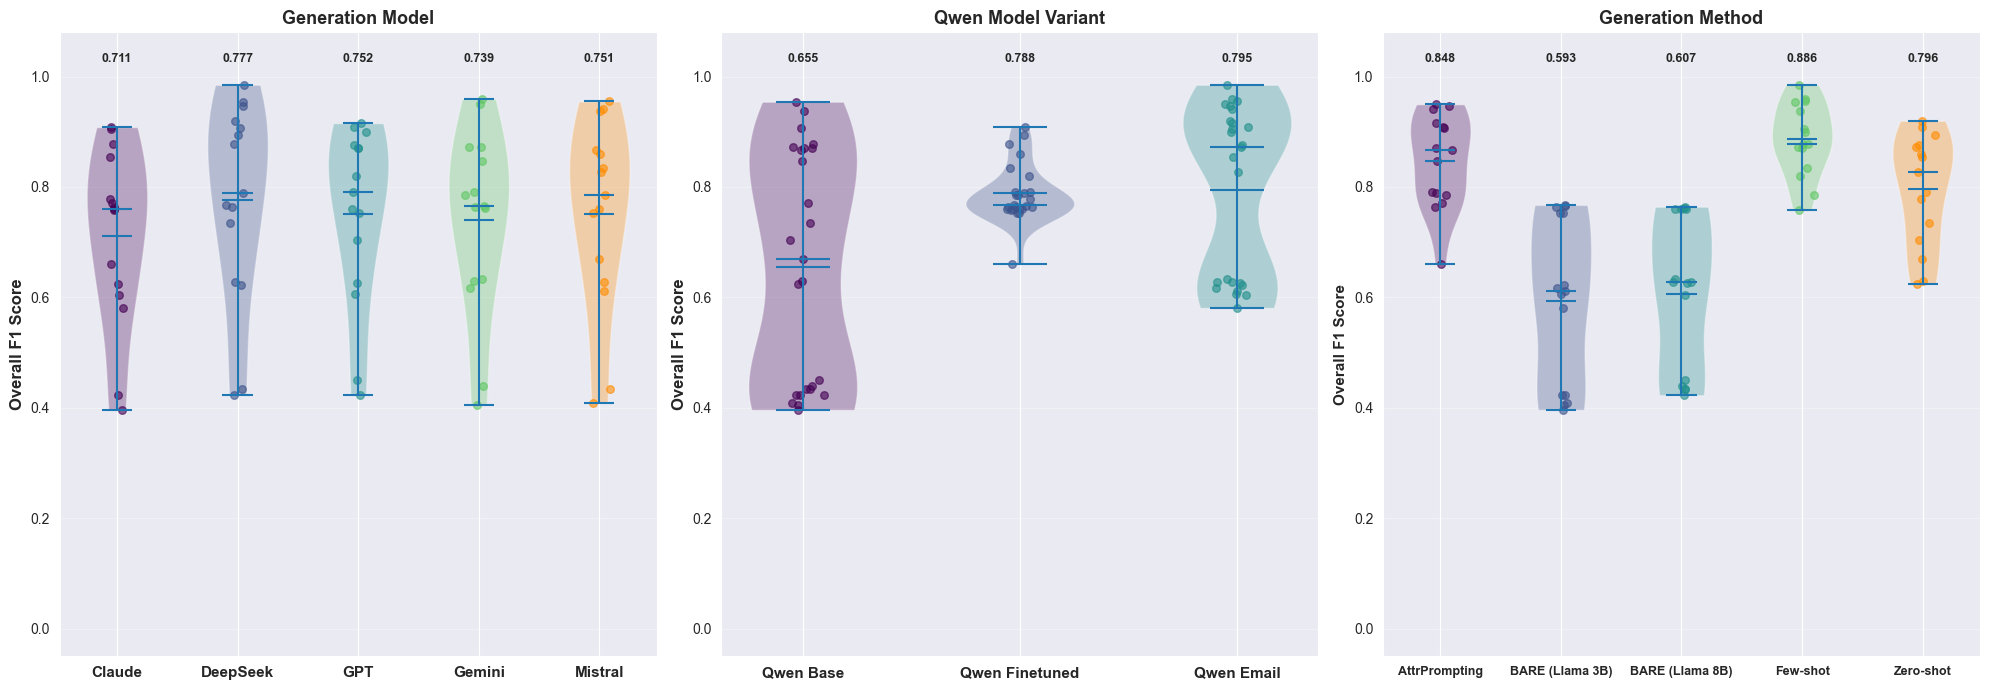

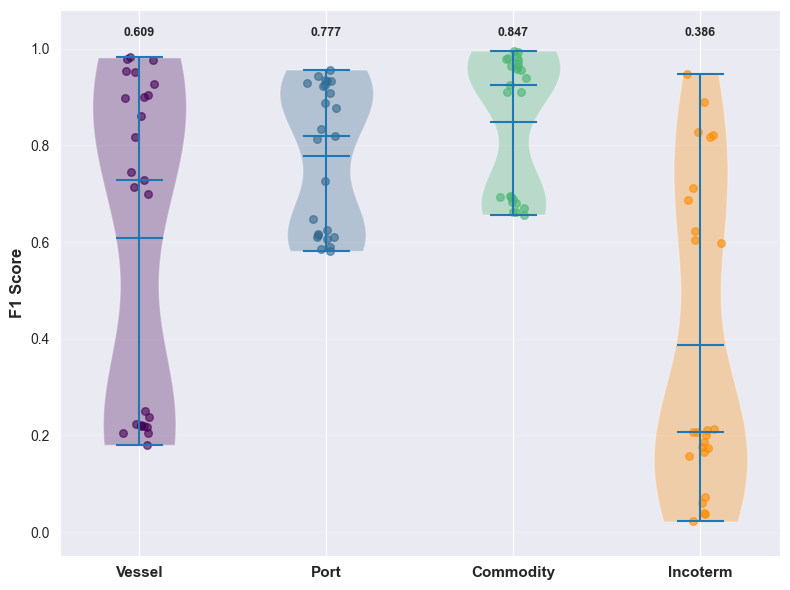

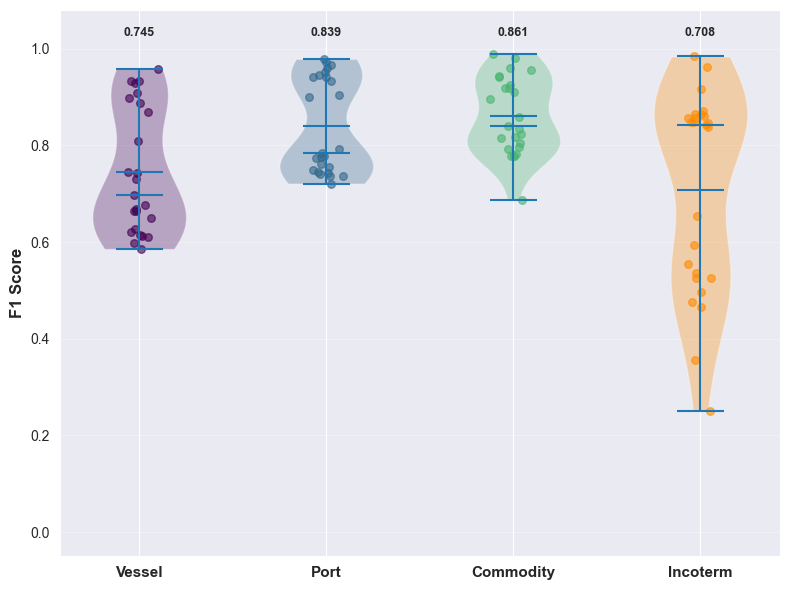

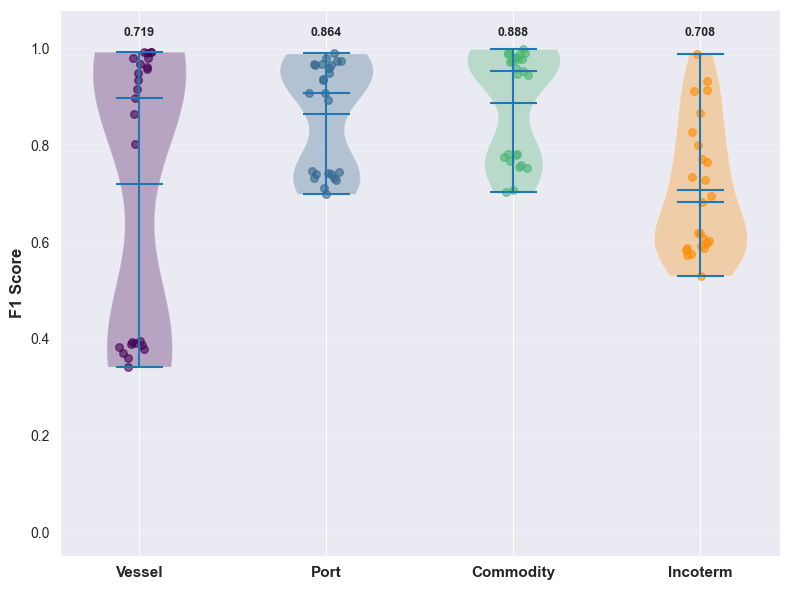

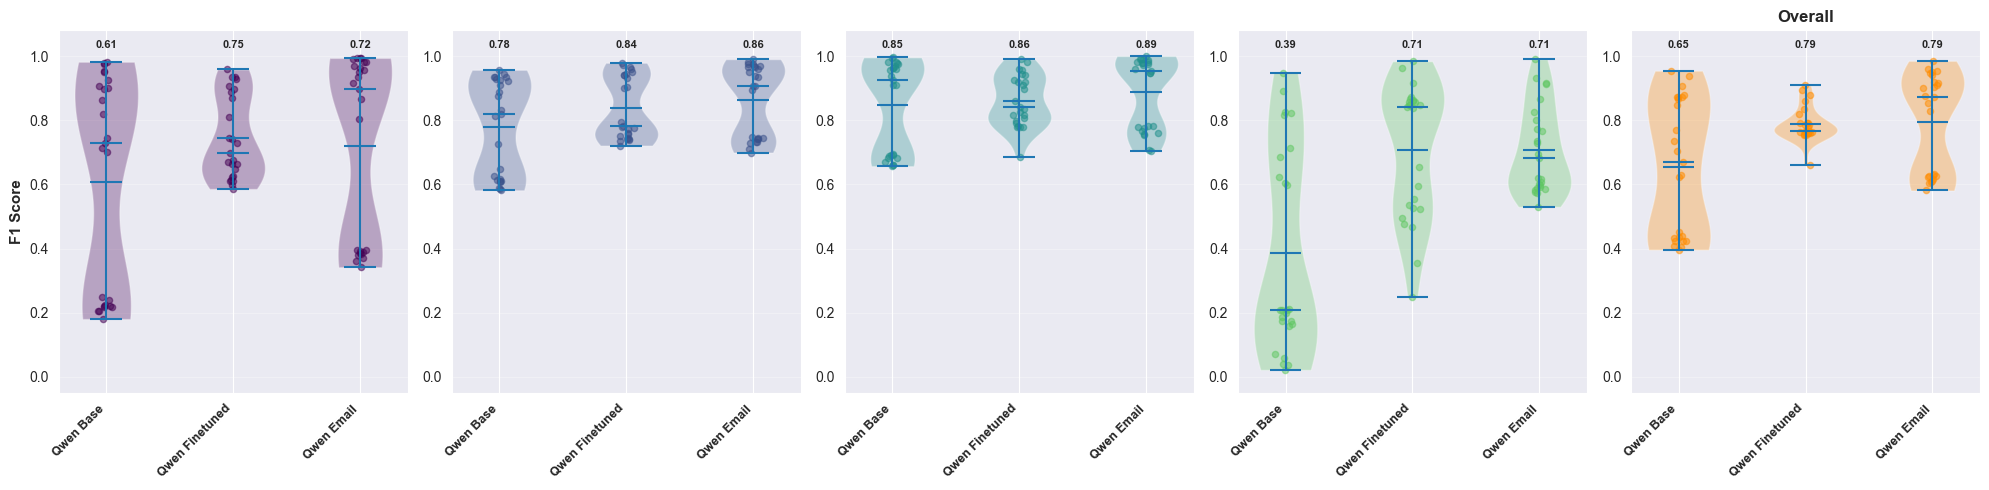


=== Summary Statistics ===

Mean F1 scores by model:
Qwen Base: 0.655
Qwen Finetuned: 0.788
Qwen Email: 0.795

Mean F1 scores by generation method:
AttrPrompting: 0.848
BARE (Llama 3B): 0.593
BARE (Llama 8B): 0.607
Few-shot: 0.886
Zero-shot: 0.796

Mean F1 scores by generation model:
Claude: 0.711
DeepSeek: 0.777
GPT: 0.752
Gemini: 0.739
Mistral: 0.751


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.cm import viridis
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------
# Data Reading
# -------------------------------------------------------------------
df = pd.read_csv(r"C:\Users\brk.ch\Work Folders\RF\Desktop\Master Thesis\Repo\Masterthesis-dev\llm_finetuning\eval_results\qwen_metrics_substring.csv")

# -------------------------------------------------------------------
# Model Groups
# -------------------------------------------------------------------
model_order = ['qwen_base', 'qwen_finetuned', 'qwen_email']

model_rename_dict = {
    'qwen_base': 'Qwen Base',
    'qwen_finetuned': 'Qwen Finetuned',
    'qwen_email': 'Qwen Email'
}

entity_types = ['vessel', 'port', 'commodity', 'incoterm']
entity_labels = ['Vessel', 'Port', 'Commodity', 'Incoterm']
all_datasets = sorted(df['dataset'].unique())

# -------------------------------------------------------------------
# Custom Color Function (Purple to Orange instead of Yellow)
# -------------------------------------------------------------------
def get_custom_colors(n):
    """Get n evenly spaced colors from purple to orange"""
    colors = ['#440154', '#3b528b', '#21908c', '#5dc863', '#fde725']
    colors = ['#440154', '#3b528b', '#21908c', '#5dc863', '#ff8c00']
    
    cmap = mcolors.LinearSegmentedColormap.from_list('purple_to_orange', colors)
    
    return [cmap(i / (n - 1)) for i in range(n)]

# -------------------------------------------------------------------
# Parsing Dataset Names
# -------------------------------------------------------------------
def parse_dataset_info(dataset_name):
    """Parse dataset name to extract generation type and model"""
    parts = dataset_name.split('_')

    if 'attr_prompting' in dataset_name:
        gen_type = 'AttrPrompting'
        model_name = parts[-1]

    elif 'bare_llama_3b' in dataset_name:
        gen_type = 'BARE (Llama 3B)'
        model_name = parts[-1]

    elif 'bare_llama_8b' in dataset_name:
        gen_type = 'BARE (Llama 8B)'
        model_name = parts[-1]

    elif 'fewshot' in dataset_name:
        gen_type = 'Few-shot'
        model_name = parts[-1]

    elif 'zeroshot' in dataset_name:
        gen_type = 'Zero-shot'
        model_name = parts[-1]

    else:
        gen_type = 'Unknown'
        model_name = dataset_name

    if model_name.lower() == 'gpt':
        model = 'GPT'
    elif model_name.lower() == 'deepseek':
        model = 'DeepSeek'
    elif model_name.lower() == 'gemini':
        model = 'Gemini'
    elif model_name.lower() == 'claude':
        model = 'Claude'
    elif model_name.lower() == 'mistral':
        model = 'Mistral'
    else:
        model = model_name.capitalize()

    return gen_type, model

# -------------------------------------------------------------------
# Calculate Overall F1 Score
# -------------------------------------------------------------------
def calculate_overall_f1(row):
    """Calculate overall F1 as average of individual entity F1 scores"""
    entity_f1s = [row['vessel_f1'], row['port_f1'], row['commodity_f1'], row['incoterm_f1']]
    return np.mean(entity_f1s)

df['overall_f1'] = df.apply(calculate_overall_f1, axis=1)

df['generation_model'] = df['dataset'].apply(lambda x: parse_dataset_info(x)[1])
df['generation_method'] = df['dataset'].apply(lambda x: parse_dataset_info(x)[0])

# -------------------------------------------------------------------
# VIOLIN PLOT VISUALIZATIONS
# -------------------------------------------------------------------

gen_model_order = sorted(df['generation_model'].unique())
gen_method_order = sorted(df['generation_method'].unique())

max_categories = max(len(gen_model_order), len(model_order), len(gen_method_order))
base_colors = get_custom_colors(max_categories)

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

ax = axes[0]
models = gen_model_order
violin_data = [df[df['generation_model'] == model]['overall_f1'].values for model in models]
violin_parts = ax.violinplot(violin_data, positions=range(len(models)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.3)

for i, model in enumerate(models):
    data = df[df['generation_model'] == model]['overall_f1'].values
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=30, color=base_colors[i])

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=12, fontweight="bold")
ax.set_title('Generation Model', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

ax = axes[1]
model_types = [model_rename_dict[m] for m in model_order if m in df['model'].unique()]
violin_data = [df[df['model'] == model]['overall_f1'].values for model in model_order if model in df['model'].unique()]
violin_parts = ax.violinplot(violin_data, positions=range(len(model_types)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.3)

for i, (model, model_type) in enumerate(zip([m for m in model_order if m in df['model'].unique()], model_types)):
    data = df[df['model'] == model]['overall_f1'].values
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=30, color=base_colors[i])

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(model_types)))
ax.set_xticklabels(model_types, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=12, fontweight="bold")
ax.set_title('Qwen Model Variant', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

ax = axes[2]
methods = gen_method_order
violin_data = [df[df['generation_method'] == method]['overall_f1'].values for method in methods]
violin_parts = ax.violinplot(violin_data, positions=range(len(methods)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.3)

for i, method in enumerate(methods):
    data = df[df['generation_method'] == method]['overall_f1'].values
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=30, color=base_colors[i])

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=9, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=11, fontweight="bold")
ax.set_title('Generation Method', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

plt.tight_layout()
plt.savefig('qwen_violin_grid_overall.png', dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------
# Entity Violin Plots Per Qwen Model
# -------------------------------------------------------------------

entity_colors = get_custom_colors(len(entity_types))

for model in model_order:
    if model in df['model'].unique():
        fig, ax = plt.subplots(figsize=(8, 6))
        
        model_data = df[df['model'] == model]
        violin_data = []
        
        for entity in entity_types:
            data = model_data[f'{entity}_f1'].values
            violin_data.append(data)
        
        violin_parts = ax.violinplot(violin_data, positions=range(len(entity_types)), 
                                   showmeans=True, showmedians=True)
        
        for i, pc in enumerate(violin_parts['bodies']):
            pc.set_facecolor(entity_colors[i])
            pc.set_alpha(0.3)
        
        for i, entity in enumerate(entity_types):
            data = model_data[f'{entity}_f1'].values
            y = data
            x = np.random.normal(i, 0.04, size=len(y))
            ax.scatter(x, y, alpha=0.6, s=30, color=entity_colors[i])
            
            mean_val = np.mean(data)
            ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', 
                   fontsize=9, fontweight='bold')
        
        ax.set_xticks(range(len(entity_types)))
        ax.set_xticklabels(entity_labels, fontsize=11, fontweight="bold")
        ax.set_ylabel('F1 Score', fontsize=12, fontweight="bold")
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(-0.05, 1.08)
        
        plt.tight_layout()
        plt.savefig(f'qwen_violin_entities_{model}.png', dpi=300, bbox_inches='tight')
        plt.show()

# -------------------------------------------------------------------
# Combined Entity Plot with Overall (no individual titles)
# -------------------------------------------------------------------

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
all_colors = get_custom_colors(5)

for idx, (entity, label) in enumerate(zip(entity_types, entity_labels)):
    ax = axes[idx]
    
    model_types = [model_rename_dict[m] for m in model_order if m in df['model'].unique()]
    violin_data = [df[df['model'] == model][f'{entity}_f1'].values 
                  for model in model_order if model in df['model'].unique()]
    violin_parts = ax.violinplot(violin_data, positions=range(len(model_types)), 
                               showmeans=True, showmedians=True)
    
    for pc in violin_parts['bodies']:
        pc.set_facecolor(all_colors[idx])
        pc.set_alpha(0.3)
    
    for i, model in enumerate([m for m in model_order if m in df['model'].unique()]):
        data = df[df['model'] == model][f'{entity}_f1'].values
        y = data
        x = np.random.normal(i, 0.03, size=len(y))
        ax.scatter(x, y, alpha=0.5, s=20, color=all_colors[idx])
        
        mean_val = np.mean(data)
        ax.text(i, 1.02, f'{mean_val:.2f}', ha='center', va='bottom', 
               fontsize=8, fontweight='bold')
    
    ax.set_xticks(range(len(model_types)))
    ax.set_xticklabels(model_types, fontsize=9, fontweight="bold", rotation=45, ha='right')
    if idx == 0:
        ax.set_ylabel('F1 Score', fontsize=11, fontweight="bold")
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(-0.05, 1.08)

ax = axes[4]
model_types = [model_rename_dict[m] for m in model_order if m in df['model'].unique()]
violin_data = [df[df['model'] == model]['overall_f1'].values 
              for model in model_order if model in df['model'].unique()]
violin_parts = ax.violinplot(violin_data, positions=range(len(model_types)), 
                           showmeans=True, showmedians=True)

for pc in violin_parts['bodies']:
    pc.set_facecolor(all_colors[4])
    pc.set_alpha(0.3)

for i, model in enumerate([m for m in model_order if m in df['model'].unique()]):
    data = df[df['model'] == model]['overall_f1'].values
    y = data
    x = np.random.normal(i, 0.03, size=len(y))
    ax.scatter(x, y, alpha=0.5, s=20, color=all_colors[4])
    
    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.2f}', ha='center', va='bottom', 
           fontsize=8, fontweight='bold')

ax.set_xticks(range(len(model_types)))
ax.set_xticklabels(model_types, fontsize=9, fontweight="bold", rotation=45, ha='right')
ax.set_title('Overall', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

plt.tight_layout()
plt.savefig('qwen_violin_entities_overall_combined.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Summary Statistics ===")
print("\nMean F1 scores by model:")
for model in model_order:
    if model in df['model'].unique():
        mean_f1 = df[df['model'] == model]['overall_f1'].mean()
        print(f"{model_rename_dict[model]}: {mean_f1:.3f}")

print("\nMean F1 scores by generation method:")
for method in gen_method_order:
    mean_f1 = df[df['generation_method'] == method]['overall_f1'].mean()
    print(f"{method}: {mean_f1:.3f}")

print("\nMean F1 scores by generation model:")
for gen_model in gen_model_order:
    mean_f1 = df[df['generation_model'] == gen_model]['overall_f1'].mean()
    print(f"{gen_model}: {mean_f1:.3f}")

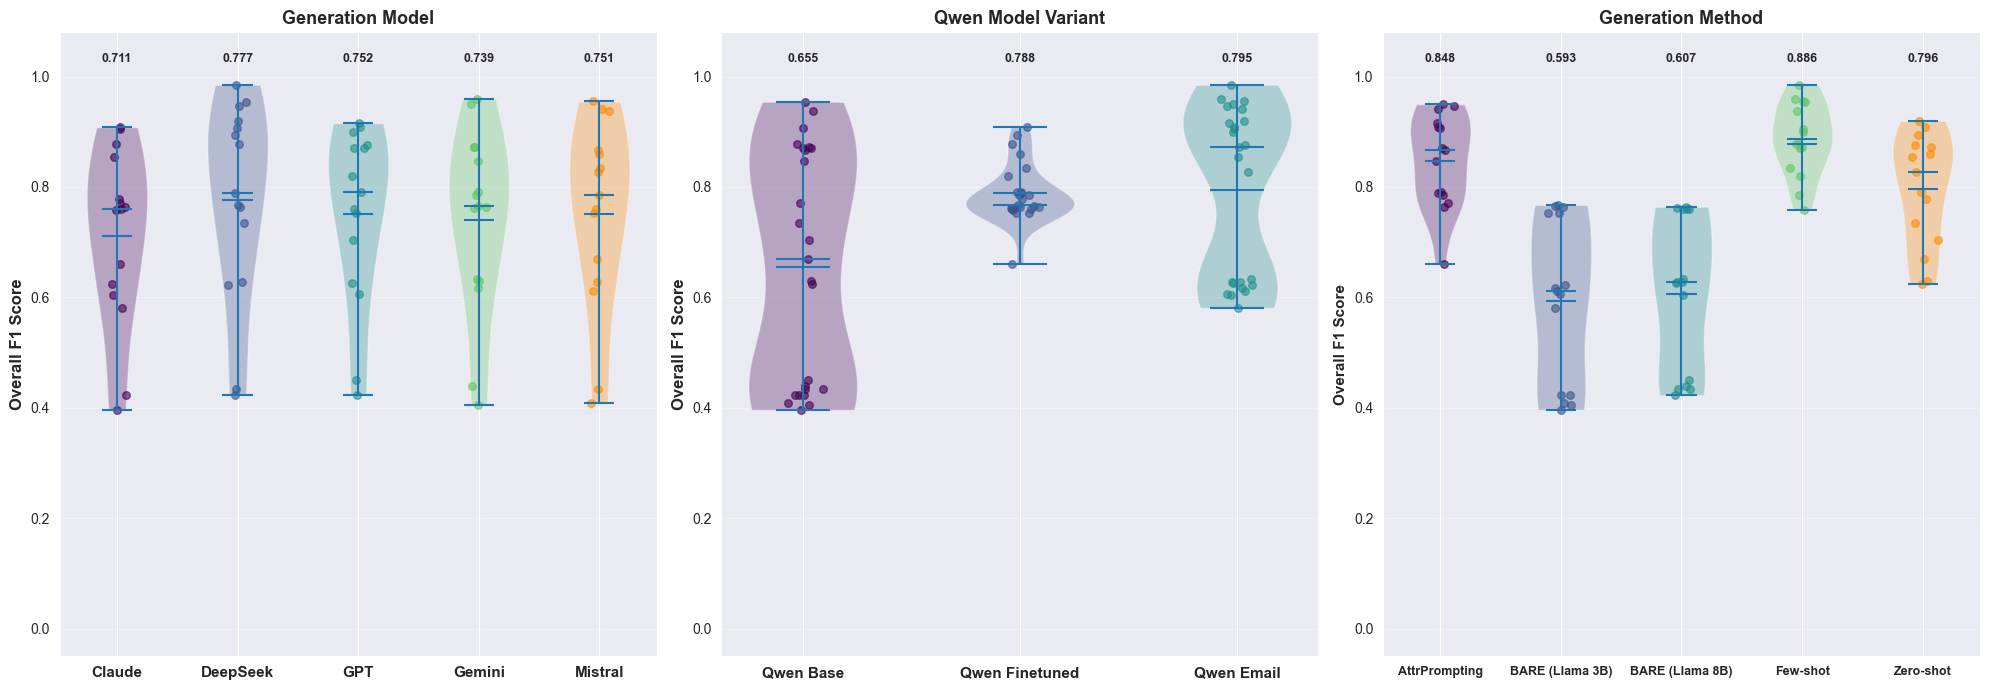

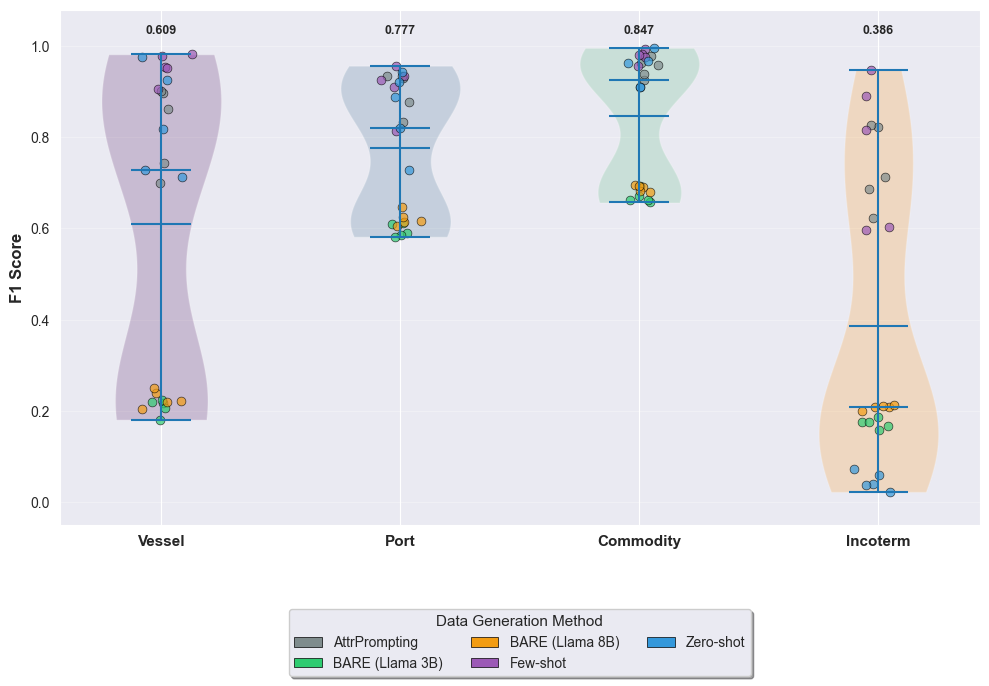

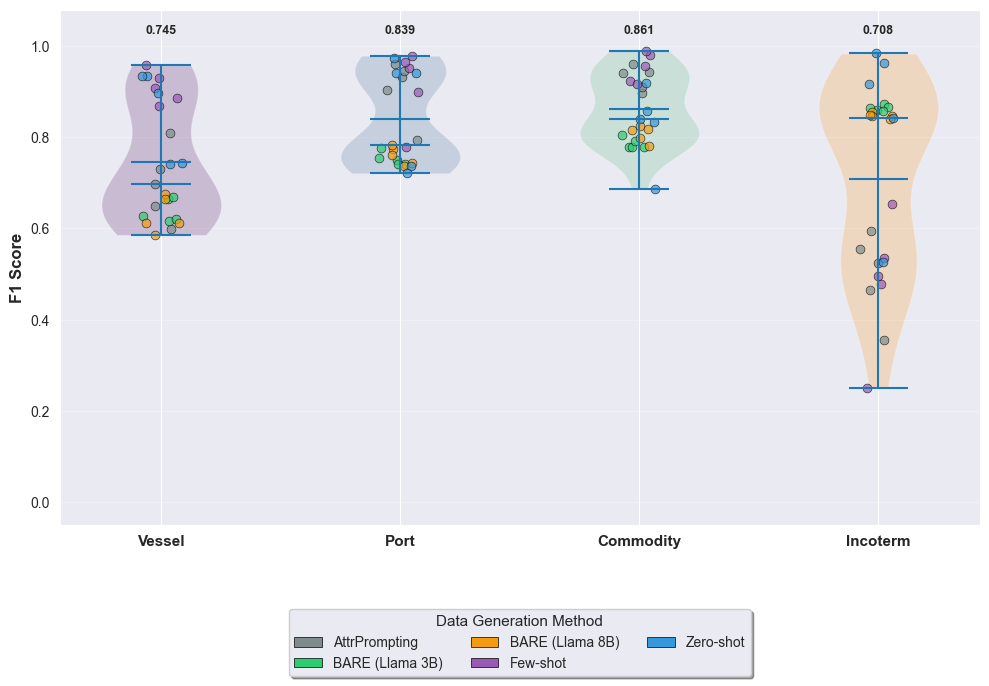

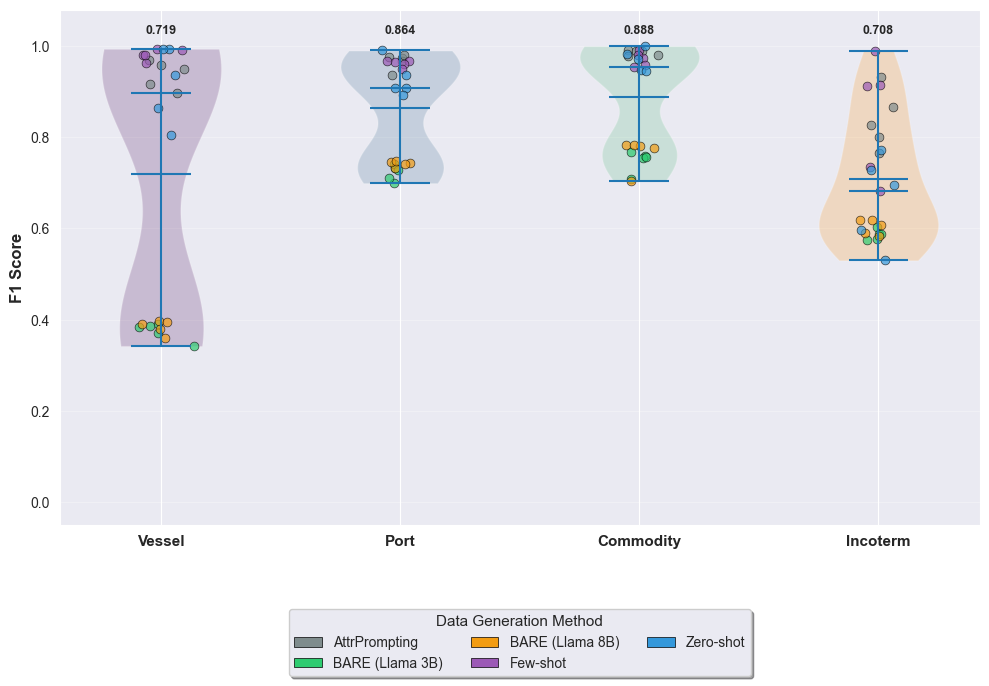

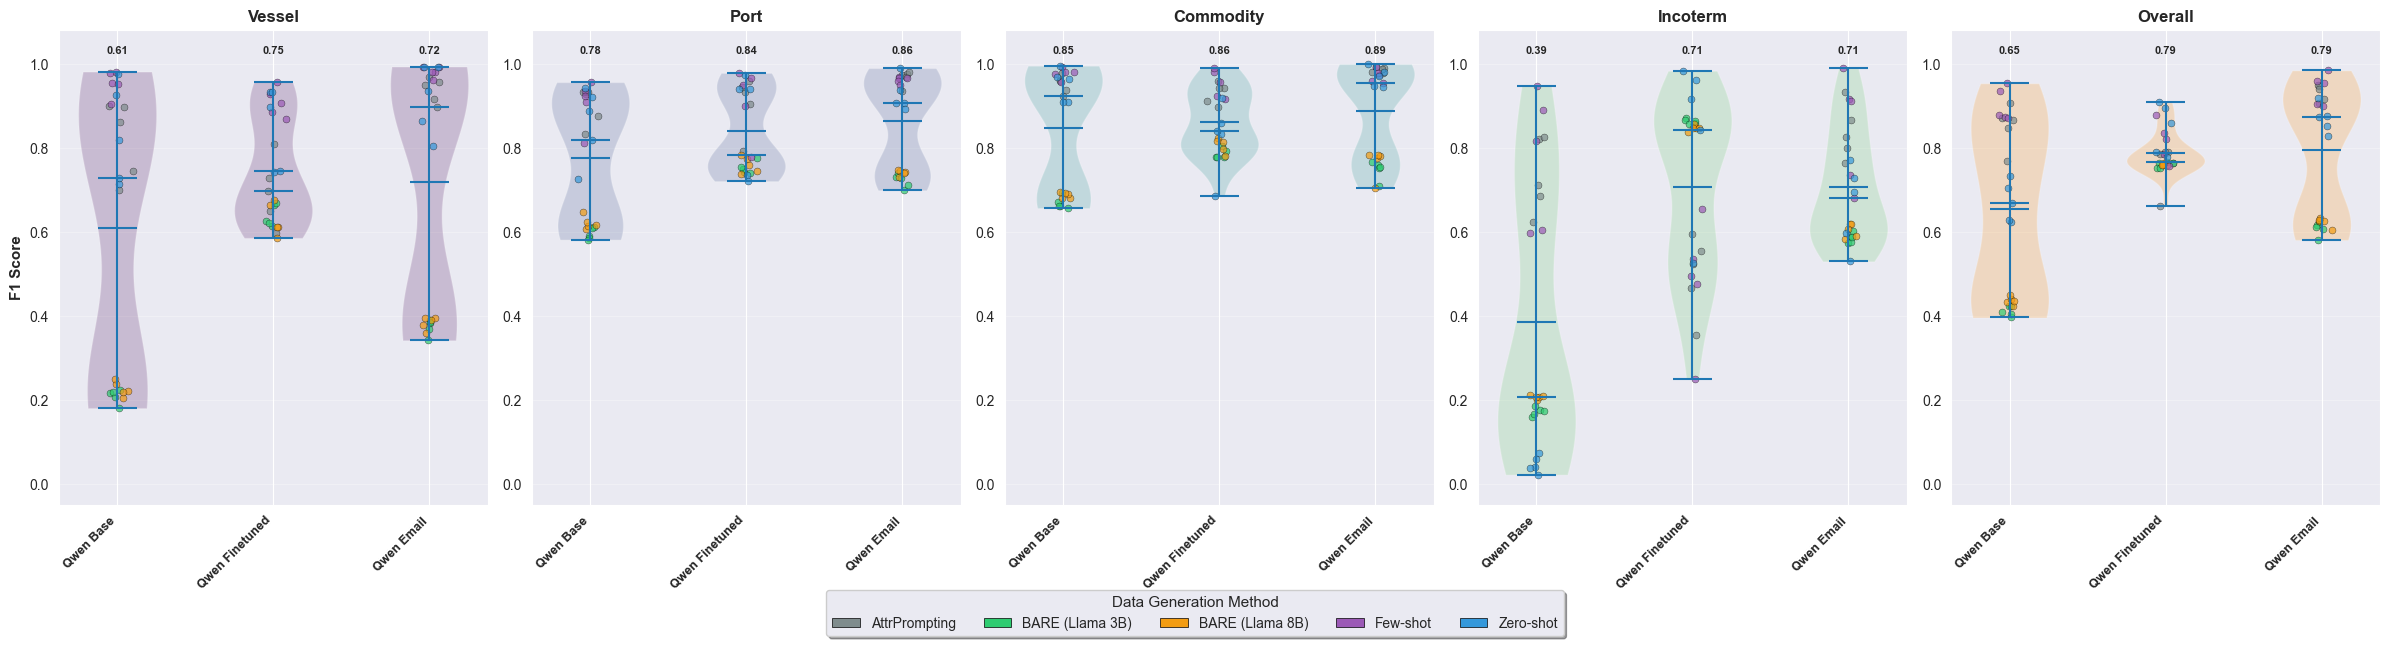


=== Summary Statistics ===

Mean F1 scores by model:
Qwen Base: 0.655
Qwen Finetuned: 0.788
Qwen Email: 0.795

Mean F1 scores by generation method:
AttrPrompting: 0.848
BARE (Llama 3B): 0.593
BARE (Llama 8B): 0.607
Few-shot: 0.886
Zero-shot: 0.796

Mean F1 scores by generation model:
Claude: 0.711
DeepSeek: 0.777
GPT: 0.752
Gemini: 0.739
Mistral: 0.751

Data generation methods found: ['AttrPrompting', 'BARE (Llama 3B)', 'BARE (Llama 8B)', 'Few-shot', 'Zero-shot']


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.cm import viridis
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------
# Data Reading
# -------------------------------------------------------------------
df = pd.read_csv(r"C:\Users\brk.ch\Work Folders\RF\Desktop\Master Thesis\Repo\Masterthesis-dev\llm_finetuning\eval_results\qwen_metrics_substring.csv")

# -------------------------------------------------------------------
# Model Groups
# -------------------------------------------------------------------
model_order = ['qwen_base', 'qwen_finetuned', 'qwen_email']

model_rename_dict = {
    'qwen_base': 'Qwen Base',
    'qwen_finetuned': 'Qwen Finetuned',
    'qwen_email': 'Qwen Email'
}

entity_types = ['vessel', 'port', 'commodity', 'incoterm']
entity_labels = ['Vessel', 'Port', 'Commodity', 'Incoterm']
all_datasets = sorted(df['dataset'].unique())

# -------------------------------------------------------------------
# Define color palette for data generation methods
# -------------------------------------------------------------------
generation_palette = {
    'Zero-shot': '#3498db',          # Blue
    'Attr. Prompting': '#e74c3c',   # Red
    'BARE (Llama 3B)': '#2ecc71',   # Green
    'BARE (Llama 8B)': '#f39c12',   # Orange
    'Few-shot': '#9b59b6',          # Purple
    'Unknown': '#7f8c8d'            # Gray (fallback)
}

# -------------------------------------------------------------------
# Custom Color Function
# -------------------------------------------------------------------
def get_custom_colors(n):
    """Get n evenly spaced colors from purple to orange"""
    colors = ['#440154', '#3b528b', '#21908c', '#5dc863', '#fde725']  # Original viridis
    colors = ['#440154', '#3b528b', '#21908c', '#5dc863', '#ff8c00']  # Dark orange instead of yellow

    cmap = mcolors.LinearSegmentedColormap.from_list('purple_to_orange', colors)

    return [cmap(i / (n - 1)) for i in range(n)]

# -------------------------------------------------------------------
# Parsing Dataset Names
# -------------------------------------------------------------------
def parse_dataset_info(dataset_name):
    """Parse dataset name to extract generation type and model"""
    parts = dataset_name.split('_')

    if 'attr_prompting' in dataset_name:
        gen_type = 'AttrPrompting'
        model_name = parts[-1]

    elif 'bare_llama_3b' in dataset_name:
        gen_type = 'BARE (Llama 3B)'
        model_name = parts[-1]

    elif 'bare_llama_8b' in dataset_name:
        gen_type = 'BARE (Llama 8B)'
        model_name = parts[-1]

    elif 'fewshot' in dataset_name:
        gen_type = 'Few-shot'
        model_name = parts[-1]

    elif 'zeroshot' in dataset_name:
        gen_type = 'Zero-shot'
        model_name = parts[-1]

    else:
        gen_type = 'Unknown'
        model_name = dataset_name

    if model_name.lower() == 'gpt':
        model = 'GPT'
    elif model_name.lower() == 'deepseek':
        model = 'DeepSeek'
    elif model_name.lower() == 'gemini':
        model = 'Gemini'
    elif model_name.lower() == 'claude':
        model = 'Claude'
    elif model_name.lower() == 'mistral':
        model = 'Mistral'
    else:
        model = model_name.capitalize()

    return gen_type, model

# -------------------------------------------------------------------
# Calculate Overall F1 Score
# -------------------------------------------------------------------
def calculate_overall_f1(row):
    """Calculate overall F1 as average of individual entity F1 scores"""
    entity_f1s = [row['vessel_f1'], row['port_f1'], row['commodity_f1'], row['incoterm_f1']]
    return np.mean(entity_f1s)

df['overall_f1'] = df.apply(calculate_overall_f1, axis=1)

df['generation_model'] = df['dataset'].apply(lambda x: parse_dataset_info(x)[1])
df['generation_method'] = df['dataset'].apply(lambda x: parse_dataset_info(x)[0])

# -------------------------------------------------------------------
# VIOLIN PLOT VISUALIZATIONS
# -------------------------------------------------------------------

gen_model_order = sorted(df['generation_model'].unique())
gen_method_order = sorted(df['generation_method'].unique())

max_categories = max(len(gen_model_order), len(model_order), len(gen_method_order))
base_colors = get_custom_colors(max_categories)

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

ax = axes[0]
models = gen_model_order
violin_data = [df[df['generation_model'] == model]['overall_f1'].values for model in models]
violin_parts = ax.violinplot(violin_data, positions=range(len(models)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.3)

for i, model in enumerate(models):
    data = df[df['generation_model'] == model]['overall_f1'].values
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=30, color=base_colors[i])

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=12, fontweight="bold")
ax.set_title('Generation Model', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

ax = axes[1]
model_types = [model_rename_dict[m] for m in model_order if m in df['model'].unique()]
violin_data = [df[df['model'] == model]['overall_f1'].values for model in model_order if model in df['model'].unique()]
violin_parts = ax.violinplot(violin_data, positions=range(len(model_types)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.3)

for i, (model, model_type) in enumerate(zip([m for m in model_order if m in df['model'].unique()], model_types)):
    data = df[df['model'] == model]['overall_f1'].values
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=30, color=base_colors[i])

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(model_types)))
ax.set_xticklabels(model_types, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=12, fontweight="bold")
ax.set_title('Qwen Model Variant', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

ax = axes[2]
methods = gen_method_order
violin_data = [df[df['generation_method'] == method]['overall_f1'].values for method in methods]
violin_parts = ax.violinplot(violin_data, positions=range(len(methods)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.3)

for i, method in enumerate(methods):
    data = df[df['generation_method'] == method]['overall_f1'].values
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=30, color=base_colors[i])

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=9, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=11, fontweight="bold")
ax.set_title('Generation Method', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

plt.tight_layout()
plt.savefig('qwen_violin_grid_overall.png', dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------
# Entity Violin Plots Per Qwen Model
# -------------------------------------------------------------------

entity_colors = get_custom_colors(len(entity_types))

for model in model_order:
    if model in df['model'].unique():
        fig, ax = plt.subplots(figsize=(10, 7))

        model_data = df[df['model'] == model]
        violin_data = []

        for entity in entity_types:
            data = model_data[f'{entity}_f1'].values
            violin_data.append(data)

        violin_parts = ax.violinplot(violin_data, positions=range(len(entity_types)),
                                   showmeans=True, showmedians=True)

        for i, pc in enumerate(violin_parts['bodies']):
            pc.set_facecolor(entity_colors[i])
            pc.set_alpha(0.2)

        legend_handles = []
        added_labels = set()

        for i, entity in enumerate(entity_types):
            for gen_method in model_data['generation_method'].unique():
                method_data = model_data[model_data['generation_method'] == gen_method]
                data = method_data[f'{entity}_f1'].values

                if len(data) > 0:
                    y = data
                    x = np.random.normal(i, 0.04, size=len(y))

                    color = generation_palette.get(gen_method, '#7f8c8d')

                    scatter = ax.scatter(x, y, alpha=0.7, s=40, color=color,
                                       edgecolors='black', linewidth=0.5)

                    if gen_method not in added_labels:
                        legend_handles.append((scatter, gen_method))
                        added_labels.add(gen_method)

            all_data = model_data[f'{entity}_f1'].values
            mean_val = np.mean(all_data)
            ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom',
                   fontsize=9, fontweight='bold')

        ax.set_xticks(range(len(entity_types)))
        ax.set_xticklabels(entity_labels, fontsize=11, fontweight="bold")
        ax.set_ylabel('F1 Score', fontsize=12, fontweight="bold")
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(-0.05, 1.08)

        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=generation_palette.get(label, '#7f8c8d'),
                                edgecolor='black', linewidth=0.5, label=label)
                          for _, label in legend_handles]
        ax.legend(handles=legend_elements, title='Data Generation Method',
                 fontsize=10, title_fontsize=11, loc='upper center',
                 bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=True,
                 fancybox=True, shadow=True)

        plt.tight_layout()
        plt.savefig(f'qwen_violin_entities_{model}_colored.png', dpi=300, bbox_inches='tight')
        plt.show()

# -------------------------------------------------------------------
# Combined Entity Plot
# -------------------------------------------------------------------

fig, axes = plt.subplots(1, 5, figsize=(24, 6))
all_colors = get_custom_colors(5)

# Plot for each entity
for idx, (entity, label) in enumerate(zip(entity_types, entity_labels)):
    ax = axes[idx]

    model_types = [model_rename_dict[m] for m in model_order if m in df['model'].unique()]
    violin_data = [df[df['model'] == model][f'{entity}_f1'].values
                  for model in model_order if model in df['model'].unique()]
    violin_parts = ax.violinplot(violin_data, positions=range(len(model_types)),
                               showmeans=True, showmedians=True)

    for pc in violin_parts['bodies']:
        pc.set_facecolor(all_colors[idx])
        pc.set_alpha(0.2)

    for i, model in enumerate([m for m in model_order if m in df['model'].unique()]):
        model_data = df[df['model'] == model]

        for gen_method in model_data['generation_method'].unique():
            method_data = model_data[model_data['generation_method'] == gen_method]
            data = method_data[f'{entity}_f1'].values

            if len(data) > 0:
                y = data
                x = np.random.normal(i, 0.03, size=len(y))
                color = generation_palette.get(gen_method, '#7f8c8d')
                ax.scatter(x, y, alpha=0.7, s=25, color=color,
                          edgecolors='black', linewidth=0.3)

        all_data = df[df['model'] == model][f'{entity}_f1'].values
        mean_val = np.mean(all_data)
        ax.text(i, 1.02, f'{mean_val:.2f}', ha='center', va='bottom',
               fontsize=8, fontweight='bold')

    ax.set_xticks(range(len(model_types)))
    ax.set_xticklabels(model_types, fontsize=9, fontweight="bold", rotation=45, ha='right')
    ax.set_title(label, fontsize=12, fontweight='bold')
    if idx == 0:
        ax.set_ylabel('F1 Score', fontsize=11, fontweight="bold")
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(-0.05, 1.08)

ax = axes[4]
model_types = [model_rename_dict[m] for m in model_order if m in df['model'].unique()]
violin_data = [df[df['model'] == model]['overall_f1'].values
              for model in model_order if model in df['model'].unique()]
violin_parts = ax.violinplot(violin_data, positions=range(len(model_types)),
                           showmeans=True, showmedians=True)

for pc in violin_parts['bodies']:
    pc.set_facecolor(all_colors[4])
    pc.set_alpha(0.2)

legend_handles = []
added_labels = set()

for i, model in enumerate([m for m in model_order if m in df['model'].unique()]):
    model_data = df[df['model'] == model]

    for gen_method in model_data['generation_method'].unique():
        method_data = model_data[model_data['generation_method'] == gen_method]
        data = method_data['overall_f1'].values

        if len(data) > 0:
            y = data
            x = np.random.normal(i, 0.03, size=len(y))
            color = generation_palette.get(gen_method, '#7f8c8d')
            scatter = ax.scatter(x, y, alpha=0.7, s=25, color=color,
                               edgecolors='black', linewidth=0.3)

            if gen_method not in added_labels:
                legend_handles.append((scatter, gen_method))
                added_labels.add(gen_method)

    all_data = df[df['model'] == model]['overall_f1'].values
    mean_val = np.mean(all_data)
    ax.text(i, 1.02, f'{mean_val:.2f}', ha='center', va='bottom',
           fontsize=8, fontweight='bold')

ax.set_xticks(range(len(model_types)))
ax.set_xticklabels(model_types, fontsize=9, fontweight="bold", rotation=45, ha='right')
ax.set_title('Overall', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=generation_palette.get(label, '#7f8c8d'),
                        edgecolor='black', linewidth=0.5, label=label)
                  for _, label in legend_handles]

fig.legend(handles=legend_elements, title='Data Generation Method',
          fontsize=10, title_fontsize=11, loc='lower center',
          bbox_to_anchor=(0.5, -0.08), ncol=len(legend_elements),
          frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('qwen_violin_entities_overall_combined_colored.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Summary Statistics ===")
print("\nMean F1 scores by model:")
for model in model_order:
    if model in df['model'].unique():
        mean_f1 = df[df['model'] == model]['overall_f1'].mean()
        print(f"{model_rename_dict[model]}: {mean_f1:.3f}")

print("\nMean F1 scores by generation method:")
for method in gen_method_order:
    mean_f1 = df[df['generation_method'] == method]['overall_f1'].mean()
    print(f"{method}: {mean_f1:.3f}")

print("\nMean F1 scores by generation model:")
for gen_model in gen_model_order:
    mean_f1 = df[df['generation_model'] == gen_model]['overall_f1'].mean()
    print(f"{gen_model}: {mean_f1:.3f}")

print("\nData generation methods found:", sorted(df['generation_method'].unique()))